<a href="https://colab.research.google.com/github/amirgraily7/AI-for-Medicine-Specialization/blob/main/Endo_Lesion_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# OPG X-Ray Medical Diagnosis with Deep Learning


##  Import Packages and Functions


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K

from keras.models import load_model

import util

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# New section


### Loading the Data


In [4]:
train_df = pd.read_csv("/content/train_updated.csv")

valid_df = pd.read_csv("/content/validation_updated.csv")

test_df = pd.read_csv("/content/test_updated.csv")

train_df.head()

,SOPInstanceUID,Label,Endodontic,image_name
0,1.2.246.512.1.2.0.4.171476767017488.170061433....,normal,0,1.2.246.512.1.2.0.4.171476767017488.170061433....
1,2.25.87940566641998042665128299490312368691,normal,0,2.25.87940566641998042665128299490312368691.png
2,2.25.321078123818796865660086423103362316620,normal,0,2.25.321078123818796865660086423103362316620.png
3,1.2.246.512.1002.1167120586.1337728619.1719251...,normal,0,1.2.246.512.1002.1167120586.1337728619.1719251...
4,1.2.246.512.1002.2900729425.1137624140.5652610...,normal,0,1.2.246.512.1002.2900729425.1137624140.5652610...


In [5]:
labels=["Endodontic"]


### Preparing Images

In [6]:
def get_train_generator(df, image_dir, x_col, y_cols, shuffle=True, 
                        batch_size=10, seed=1, target_w = 300, target_h = 600):
    """
    Return generator for training set, normalizing using batch
    statistics.

    Args:
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        train_generator (DataFrameIterator): iterator over training set
    """        
    print("getting train generator...") 
    # normalize images
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True)
    
    # flow from directory with specified batch size
    # and target image size
    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w,target_h))
    
    return generator

In [7]:
def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols, sample_size=150, 
                                 batch_size=10, seed=1, target_w = 300 ,target_h = 600):
    """
    Return generator for validation set and test set using 
    normalization statistics from training set.

    Args:
      valid_df (dataframe): dataframe specifying validation data.
      test_df (dataframe): dataframe specifying test data.
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      sample_size (int): size of sample to use for normalization statistics.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        test_generator (DataFrameIterator) and valid_generator: iterators over test set and validation set respectively
    """
    print("getting train and valid generators...")
    # get generator to sample dataset
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df, 
        directory=IMAGE_DIR, 
        x_col=x_col, 
        y_col=y_cols, 
        class_mode="raw", 
        batch_size=sample_size, 
        shuffle=True, 
        target_size=(target_w, target_h))
    # get data sample
    batch = raw_train_generator.next()
    data_sample = batch[0]

    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)
    
    # fit generator to sample from training data
    image_generator.fit(data_sample)

    # get test generator
    valid_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))

    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    return valid_generator, test_generator

In [8]:
IMAGE_DIR ="/content/drive/MyDrive/images"
train_generator = get_train_generator(train_df, IMAGE_DIR, "image_name", labels)
valid_generator, test_generator = get_test_and_valid_generator(valid_df, test_df, train_df, IMAGE_DIR, "image_name", labels)

getting train generator...
Found 472 validated image filenames.
getting train and valid generators...
Found 472 validated image filenames.
Found 118 validated image filenames.
Found 253 validated image filenames.


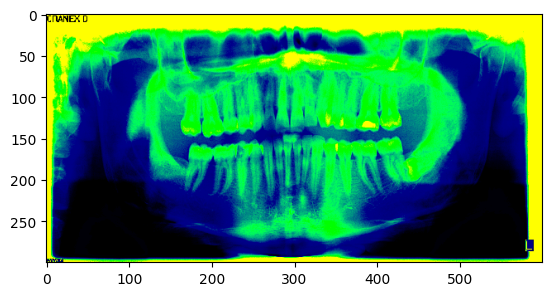

In [9]:
x, y = train_generator.__getitem__(0)
plt.imshow(x[0]);

### Addressing Class Imbalance


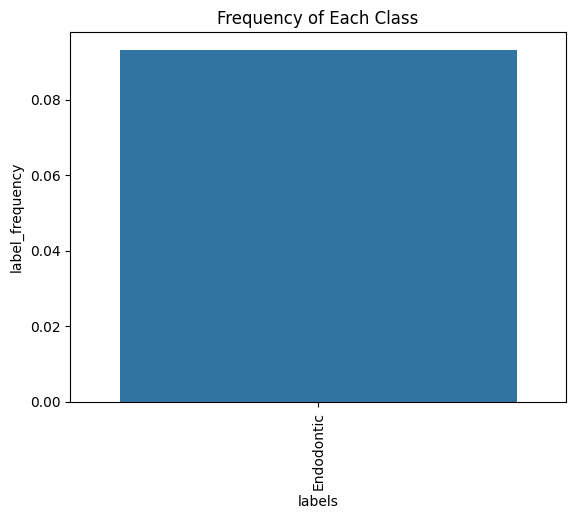

In [10]:
import pandas as pd
import seaborn as sns
label_frequency=np.mean(train_generator.labels, axis=0).tolist()
df=pd.DataFrame({"labels":labels,"label_frequency":label_frequency})
sns.barplot(x="labels",
           y="label_frequency",
           data=df,
           order=df.sort_values("label_frequency").labels)
plt.xticks(rotation=90)
# plt.bar(x=labels, height=np.mean(train_generator.labels, axis=0))
plt.title("Frequency of Each Class")
plt.show()

###  Compute Class Frequencies


In [11]:
def compute_class_freqs(labels):
    """
    Compute positive and negative frequences for each class.

    Args:
        labels (np.array): matrix of labels, size (num_examples, num_classes)
    Returns:
        positive_frequencies (np.array): array of positive frequences for each
                                         class, size (num_classes)
        negative_frequencies (np.array): array of negative frequences for each
                                         class, size (num_classes)
    """
    
    # total number of patients (rows)
    N = labels.shape[0]
    
    a_pos=labels
    dim=a_pos.shape
    a_neg=np.ones(dim)-a_pos
    positive_frequencies = np.sum(a_pos,axis=0)/N
    negative_frequencies = np.sum(a_neg,axis=0)/N

    ### END CODE HERE ###
    return positive_frequencies, negative_frequencies

Now we'll compute frequencies for our training data.

In [12]:
freq_pos, freq_neg = compute_class_freqs(train_generator.labels)
freq_pos

array([0.09322034])

<ipython-input-13-9ab347a797ed>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)


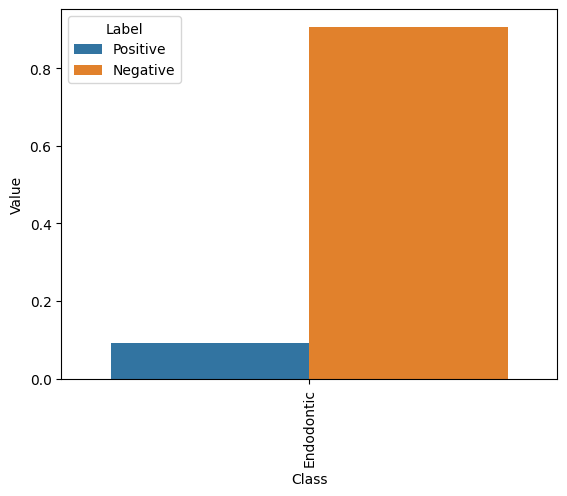

In [13]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)
plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=data,order=data.loc[data.Label=="Positive"].sort_values("Value").Class)

In [14]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights

Let's verify this by graphing the two contributions next to each other again:

<ipython-input-15-4ac96d8d4142>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v}


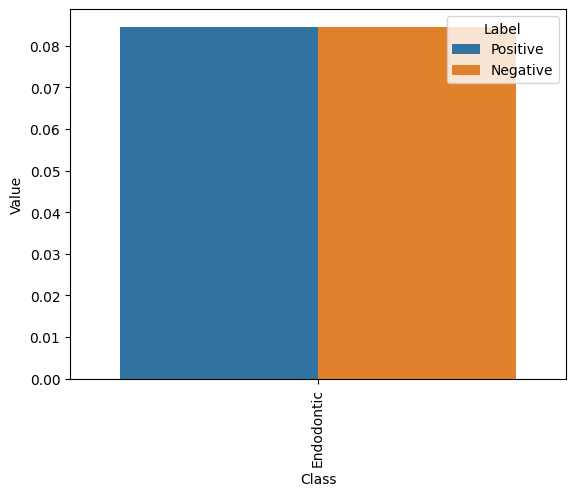

In [15]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} 
                        for l,v in enumerate(neg_contribution)], ignore_index=True)
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label" ,data=data,order=data.loc[data.Label.isin(["Positive"])].sort_values("Value").Class);

### Exercise 3 - Get Weighted Loss


In [16]:
def get_weighted_loss(pos_weights, neg_weights, epsilon=0.0001):
    """
    Return weighted loss function given negative weights and positive weights.

    Args:
      pos_weights (np.array): array of positive weights for each class, size (num_classes)
      neg_weights (np.array): array of negative weights for each class, size (num_classes)
    
    Returns:
      weighted_loss (function): weighted loss function
    """
    def weighted_loss(y_true, y_pred):
        """
        Return weighted loss value. 

        Args:
            y_true (Tensor): Tensor of true labels, size is (num_examples, num_classes)
            y_pred (Tensor): Tensor of predicted labels, size is (num_examples, num_classes)
        Returns:
            loss (float): overall scalar loss summed across all classes
        """
        # initialize loss to zero
        loss = 0.0
        y_true=tf.cast(y_true, tf.float32)
        y_pred=tf.cast(y_pred, tf.float32)


        for i in range(len(pos_weights)):
            
            # for each class, add average weighted loss for that class
            loss_pos=-1*K.mean(pos_weights[i] * y_true[:, i] * K.log(y_pred[:, i] + epsilon))
            loss_neg=-1 * K.mean(neg_weights[i] * (1 - y_true[:, i]) * K.log(1 - y_pred[:, i] + epsilon))
            loss += loss_pos + loss_neg 
        return loss
    
    return weighted_loss

### DenseNet121


In [17]:
# create the base pre-trained model
base_model = DenseNet121(weights="/content/densenet.hdf5", include_top=False)

x = base_model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

# and a logistic layer
predictions = Dense(len(labels), activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss=get_weighted_loss(pos_weights, neg_weights))

## Training


<ipython-input-21-9824dd80928f>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, validation_data=valid_generator,


Epoch 1/30
48/48 [==============================] - 138s 3s/step - loss: 0.1079 - val_loss: 0.4993
Epoch 2/30
48/48 [==============================] - 136s 3s/step - loss: 0.1163 - val_loss: 0.3364
Epoch 3/30
48/48 [==============================] - 135s 3s/step - loss: 0.1129 - val_loss: 0.7602
Epoch 4/30
48/48 [==============================] - 134s 3s/step - loss: 0.1054 - val_loss: 0.2816
Epoch 5/30
48/48 [==============================] - 135s 3s/step - loss: 0.1089 - val_loss: 0.3321
Epoch 6/30
48/48 [==============================] - 135s 3s/step - loss: 0.0938 - val_loss: 0.3807
Epoch 7/30
48/48 [==============================] - 137s 3s/step - loss: 0.1024 - val_loss: 0.3028
Epoch 8/30
48/48 [==============================] - 137s 3s/step - loss: 0.1108 - val_loss: 0.5865
Epoch 9/30
48/48 [==============================] - 153s 3s/step - loss: 0.1020 - val_loss: 0.7634


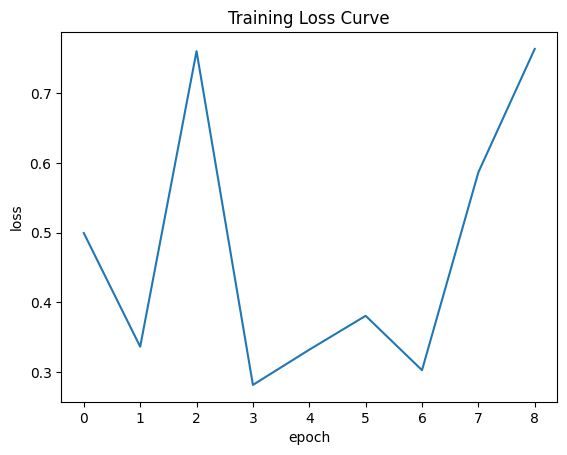

In [21]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)
history = model.fit_generator(train_generator, validation_data=valid_generator,
                              steps_per_epoch=48, 
                              validation_steps=12, 
                              epochs = 30,
                              callbacks=[early_stop])

plt.plot(history.history['val_loss'])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Training Loss Curve")
plt.show()

In [ ]:
#  model.load_weights(r"C:\Users\amirg\Desktop\MDI Competition\data\concat_v2&v3\models\nih\pretrained_model.h5")

## Prediction and Evaluation

In [1]:
predicted_vals = model.predict_generator(test_generator, steps = len(test_generator))

NameError: ignored

In [ ]:
predicted_vals.shape

In [ ]:
predicted_vals

###  ROC Curve and AUROC


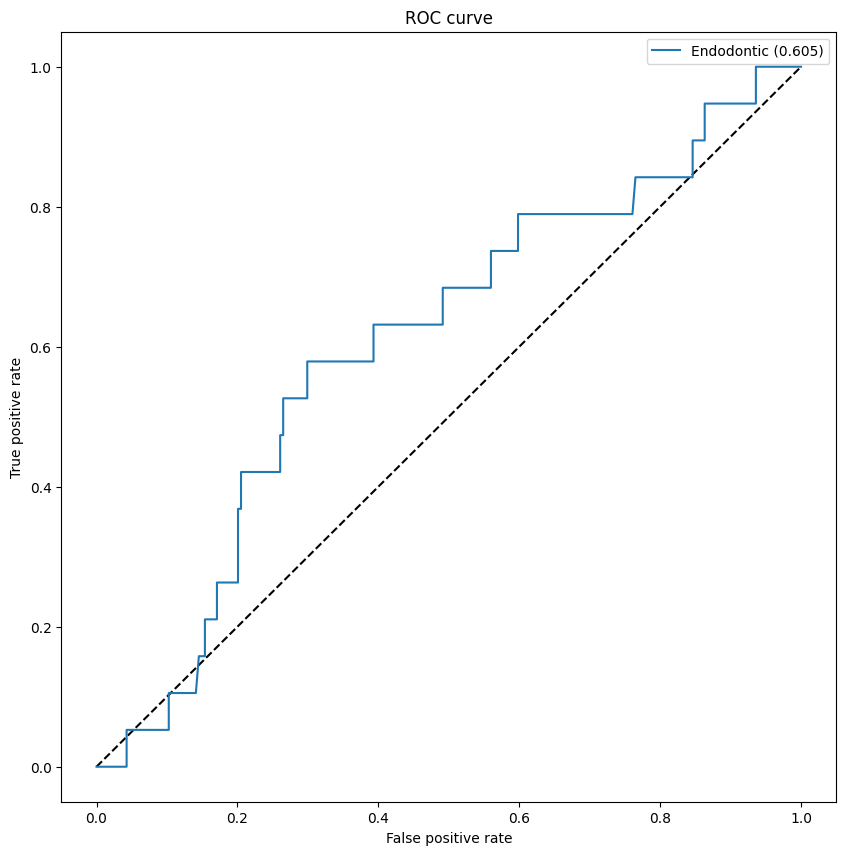

In [20]:
auc_rocs = util.get_roc_curve(labels, predicted_vals, test_generator)

In [ ]:
auc_rocs

[0.5475254885301615]

<a name='5-2'></a>
### 5.2 Visualizing Learning with GradCAM 

One of the challenges of using deep learning in medicine is that the complex architecture used for neural networks makes them much harder to interpret compared to traditional machine learning models (e.g. linear models). 

One of the most common approaches aimed at increasing the interpretability of models for computer vision tasks is to use Class Activation Maps (CAM). 
- Class activation maps are useful for understanding where the model is "looking" when classifying an image. 

In this section we will use a [GradCAM's](https://arxiv.org/abs/1610.02391) technique to produce a heatmap highlighting the important regions in the image for predicting the pathological condition. 
- This is done by extracting the gradients of each predicted class, flowing into our model's final convolutional layer. Look at the `util.compute_gradcam` which has been provided for you in `util.py` to see how this is done with the Keras framework. 

It is worth mentioning that GradCAM does not provide a full explanation of the reasoning for each classification probability. 
- However, it is still a useful tool for "debugging" our model and augmenting our prediction so that an expert could validate that a prediction is indeed due to the model focusing on the right regions of the image.

First we will load the small training set and setup to look at the 4 classes with the highest performing AUC measures.

In [ ]:
df = pd.read_csv("data/nih/train-small.csv")
IMAGE_DIR = "data/nih/images-small/"

# only show the labels with top 4 AUC
labels_to_show = np.take(labels, np.argsort(auc_rocs)[::-1])[:4]

In [ ]:
df[df.Image=='00005410_000.png']

,Image,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,PatientId,Pleural_Thickening,Pneumonia,Pneumothorax
17,00005410_000.png,0,0,0,0,0,0,0,0,0,1,0,5410,0,0,0


Now let's look at a few specific images.

Loading original image
Generating gradcam for class Cardiomegaly
Generating gradcam for class Mass
Generating gradcam for class Pneumothorax
Generating gradcam for class Edema


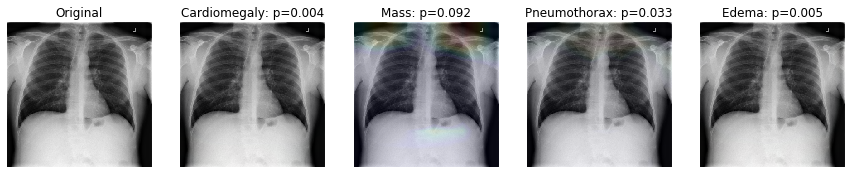

In [ ]:
util.compute_gradcam(model, '00008270_015.png', IMAGE_DIR, df, labels, labels_to_show)

Loading original image
Generating gradcam for class Cardiomegaly
Generating gradcam for class Mass
Generating gradcam for class Pneumothorax
Generating gradcam for class Edema


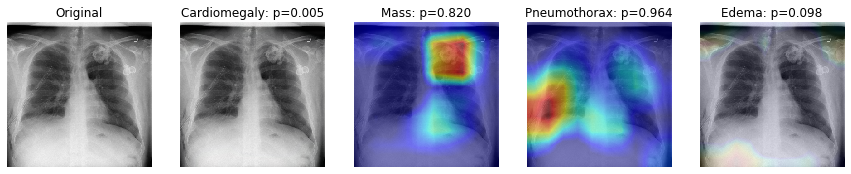

In [ ]:
util.compute_gradcam(model, '00011355_002.png', IMAGE_DIR, df, labels, labels_to_show)

Loading original image
Generating gradcam for class Cardiomegaly
Generating gradcam for class Mass
Generating gradcam for class Pneumothorax
Generating gradcam for class Edema


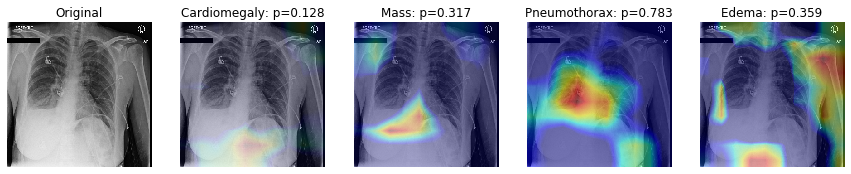

In [ ]:
util.compute_gradcam(model, '00029855_001.png', IMAGE_DIR, df, labels, labels_to_show)

Loading original image
Generating gradcam for class Cardiomegaly
Generating gradcam for class Mass
Generating gradcam for class Pneumothorax
Generating gradcam for class Edema


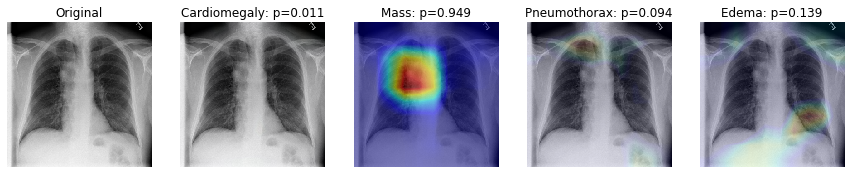

In [ ]:
util.compute_gradcam(model, '00005410_000.png', IMAGE_DIR, df, labels, labels_to_show)

Congratulations, you've completed the first assignment of course one! You've learned how to preprocess data, check for data leakage, train a pre-trained model, and evaluate using the AUC. Great work!